<h2>Population and Available Amenities in Metro Toronto</h2>

#### Methodology

##### Data Import and Cleansing

Import Relevant packages from python libraries. 

In [1]:
import requests 
from bs4 import BeautifulSoup
import pandas as pd
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3
import numpy as np
from geopy.geocoders import Nominatim
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors


Scrape Metro Toronto Area (MTA) Postal Code, Neighborhood, and Borough data from wikipedia.

In [168]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
response = requests.get(url)
soup = BeautifulSoup(response.text, 'html.parser')
table = soup.find('table',{'class': 'wikitable sortable'}).tbody




    
   

In [169]:
rows = table.find_all('tr')
columns = [v.text.replace('\n','') for v in rows[0].find_all('th')]

df = pd.DataFrame(columns = columns)

In [170]:
for i in range(1, len(rows)):
    tds = rows[i].find_all('td')
    
    if len(tds) == 2:
        values = [tds[0].text,tds[1].text,'']
    else:
        values = [td.text.replace('\n','') for td in tds]
    
    df = df.append(pd.Series(values, index = columns),ignore_index = True)
    

Clean Data

In [171]:
# Remove Records where Bourough is 'Not Assigned'
df = df[df.Borough != 'Not assigned']
df.reset_index(drop = True, inplace = True)

#Replace slash with comma for readibility
df = df.replace(regex = [' /'], value = ',')



Import and Merge Latitude and Longitude data elements from exterior csv file.

In [172]:
# The code was removed by Watson Studio for sharing.

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [173]:
df = pd.merge(df,  
                      lat_long,  
                      left_on ='Postal Code', right_on = 'Postal Code', how ='left') 

#del df['Postal Code']
df.head()



,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494


Import and merge Canadian Population Data with Postal Code data frame.

In [174]:

body = client_0cac3b5226434df4afeb5e53fe6c1f81.get_object(Bucket='courseracapstoneproject-donotdelete-pr-fhi9wjy4xbg1in',Key='canada_population_2016.CSV')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

# If you are reading an Excel file into a pandas DataFrame, replace `read_csv` by `read_excel` in the next statement.
can_pop= pd.read_csv(body)

df = pd.merge(df,  
                      can_pop,  
                      left_on ='Postal Code', right_on = 'Geographic code',  
                      how ='left') 


df.head()


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Geographic code,Geographic name,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,M3A,North York,Parkwoods,43.753259,-79.329656,M3A,M3A,Ontario,NaN,34615.0,13847.0,13241.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,M4A,M4A,Ontario,NaN,14443.0,6299.0,6170.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,M5A,M5A,Ontario,NaN,41078.0,24186.0,22333.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,M6A,M6A,Ontario,NaN,21048.0,8751.0,8074.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,M7A,M7A,Ontario,NaN,10.0,6.0,5.0


In [175]:
del df['Geographic code']
del df['Geographic name']

np.shape(df)

(103, 10)

In [176]:
df.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,M3A,North York,Parkwoods,43.753259,-79.329656,Ontario,NaN,34615.0,13847.0,13241.0
1,M4A,North York,Victoria Village,43.725882,-79.315572,Ontario,NaN,14443.0,6299.0,6170.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,Ontario,NaN,41078.0,24186.0,22333.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,Ontario,NaN,21048.0,8751.0,8074.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,Ontario,NaN,10.0,6.0,5.0


##### Connect to Four Square API


In [177]:
CLIENT_ID = 'RGJCKSF5EHK4ECOGASXU1WXIPM2F0HSR3FVQVR3T3YBQ2EGU' # your Foursquare ID
CLIENT_SECRET = 'KSWPXKPGLJDNRAY1E0RTRA10S1AOB5MXPHEI5JDIXO3OK1EA' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
radius = 500
LIMIT = 30

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: RGJCKSF5EHK4ECOGASXU1WXIPM2F0HSR3FVQVR3T3YBQ2EGU
CLIENT_SECRET:KSWPXKPGLJDNRAY1E0RTRA10S1AOB5MXPHEI5JDIXO3OK1EA


Create Function that generates all venues for all neighborhoods

In [178]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Pull Data from FourSquare API

In [87]:
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Create List of Unique Venue Categories from toronto_venues

Segrate Data for Problem Number 1: Regression of quick service restaurants to population and dwelling volume. Quick service restaurants are defined as having a Venue Category of: Fast Food Restaurant, Coffee Shop, Sandwich Place, or Breakfast Spot

In [179]:
q1_ven_types = ["Fast Food Restaurant", "Coffee Shop", "Sandwich Place", "Breakfast Spot"]
q1_data = toronto_venues[toronto_venues['Venue Category'].isin(q1_ven_types)]
q1_data.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
5,Victoria Village,43.725882,-79.315572,Tim Hortons,43.725517,-79.313103,Coffee Shop
11,"Regent Park, Harbourfront",43.654260,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
12,"Regent Park, Harbourfront",43.654260,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
19,"Regent Park, Harbourfront",43.654260,-79.360636,Figs Breakfast & Lunch,43.655675,-79.364503,Breakfast Spot
22,"Regent Park, Harbourfront",43.654260,-79.360636,Rooster Coffee,43.651900,-79.365609,Coffee Shop


In [180]:
q1_ct = q1_data.groupby(['Neighborhood','Neighborhood Latitude','Neighborhood Longitude']).count()
del q1_ct['Venue Latitude']
del q1_ct['Venue Longitude']
del q1_ct['Venue Category']
q1_ct.sort_values(by = ['Venue'], ascending = False, axis = 0, inplace = True)

q1_ct.head()

,,,Venue
Neighborhood,Neighborhood Latitude,Neighborhood Longitude,
"Regent Park, Harbourfront",43.654260,-79.360636,8
Central Bay Street,43.657952,-79.387383,8
"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,8
"Toronto Dominion Centre, Design Exchange",43.647177,-79.381576,6
Leaside,43.709060,-79.363452,5


In [211]:
q1ct = pd.merge(q1_ct, df, how = 'left', left_on = ['Neighborhood','Neighborhood Latitude','Neighborhood Longitude'], right_on = ['Neighborhood', 'Latitude', 'Longitude'])
q1ct.head()

,Neighborhood,Venue,Postal Code,Borough,Latitude,Longitude,Province or territory,"Incompletely enumerated Indian reserves and Indian settlements, 2016","Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016"
0,"Regent Park, Harbourfront",8,M5A,Downtown Toronto,43.654260,-79.360636,Ontario,NaN,41078.0,24186.0,22333.0
1,Central Bay Street,8,M5G,Downtown Toronto,43.657952,-79.387383,Ontario,NaN,8423.0,5876.0,4929.0
2,"Queen's Park, Ontario Provincial Government",8,M7A,Downtown Toronto,43.662301,-79.389494,Ontario,NaN,10.0,6.0,5.0
3,"Toronto Dominion Centre, Design Exchange",6,M5K,Downtown Toronto,43.647177,-79.381576,Ontario,NaN,0.0,1.0,1.0
4,Leaside,5,M4G,East York,43.709060,-79.363452,Ontario,NaN,19076.0,8108.0,7731.0


In [212]:
del q1ct['Incompletely enumerated Indian reserves and Indian settlements, 2016']

Create additional features for per capita rates

In [213]:
q1ct['Venue_per_Capita'] = q1ct['Population, 2016'] / q1ct['Venue']
q1ct['Venue_per_Dwelling'] = q1ct['Total private dwellings, 2016'] / q1ct['Venue']

In [214]:
np.shape(q1ct)

(61, 12)

In [215]:
q1ct = q1ct.dropna()

In [216]:
np.shape(q1ct)

(60, 12)

In [217]:
q1ct.head()

,Neighborhood,Venue,Postal Code,Borough,Latitude,Longitude,Province or territory,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",Venue_per_Capita,Venue_per_Dwelling
0,"Regent Park, Harbourfront",8,M5A,Downtown Toronto,43.654260,-79.360636,Ontario,41078.0,24186.0,22333.0,5134.750,3023.250000
1,Central Bay Street,8,M5G,Downtown Toronto,43.657952,-79.387383,Ontario,8423.0,5876.0,4929.0,1052.875,734.500000
2,"Queen's Park, Ontario Provincial Government",8,M7A,Downtown Toronto,43.662301,-79.389494,Ontario,10.0,6.0,5.0,1.250,0.750000
3,"Toronto Dominion Centre, Design Exchange",6,M5K,Downtown Toronto,43.647177,-79.381576,Ontario,0.0,1.0,1.0,0.000,0.166667
4,Leaside,5,M4G,East York,43.709060,-79.363452,Ontario,19076.0,8108.0,7731.0,3815.200,1621.600000


### Pearson Correlation of Population and Dwelling

In [188]:
from scipy.stats import pearsonr
pop_corr = pearsonr(q1ct['Population, 2016'], q1ct['Venue'])
pop_corr

(-0.130227072374311, 0.3213213381973053)

In [189]:
dwell_corr = pearsonr(q1ct['Total private dwellings, 2016'], q1ct['Venue'])
dwell_corr

(-0.0713313647634122, 0.5880954444715327)

In [190]:
import matplotlib.pyplot as plt
%matplotlib inline

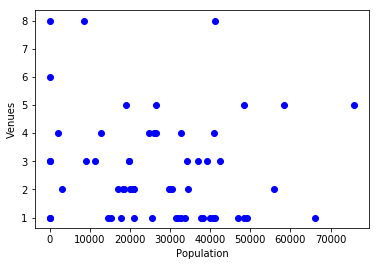

In [191]:
plt.scatter(q1ct['Population, 2016'],q1ct.Venue, color = 'blue')
plt.xlabel("Population")
plt.ylabel("Venues")
plt.show()

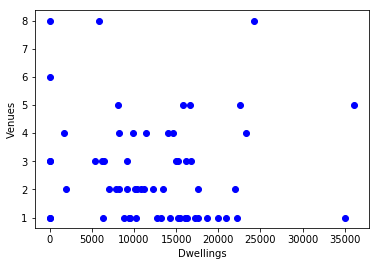

In [192]:
plt.scatter(q1ct['Total private dwellings, 2016'],q1ct.Venue, color = 'blue')
plt.xlabel("Dwellings")
plt.ylabel("Venues")
plt.show()

#### Logistic Regression Data Preprocessing

In [193]:
q1ct['Venue'] = q1ct['Venue'].astype('int')
q1ct['Total private dwellings, 2016'] = q1ct['Total private dwellings, 2016'].astype('int')
q1ct['Population, 2016'] = q1ct['Population, 2016'].astype('int')

x = np.asarray(q1ct[['Total private dwellings, 2016','Population, 2016','Venue_per_Capita','Venue_per_Dwelling']])
x[0:5]

y = np.asarray(q1ct['Venue'])
y [0:5]


array([8, 8, 8, 6, 5])

Normalize Data Set

In [194]:
from sklearn import preprocessing
x = preprocessing.StandardScaler().fit(x).transform(x)
x[0:5]

array([[ 1.53558249,  0.80194524, -0.74299513, -0.62716008],
       [-0.84862109, -1.11986079, -1.00785627, -0.95455614],
       [-1.61297253, -1.61498111, -1.07609319, -1.05951599],
       [-1.6136236 , -1.61556963, -1.0761743 , -1.05959943],
       [-0.55798524, -0.4929124 , -0.82861694, -0.82766021]])

In [195]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (48, 4) (48,)
Test set: (12, 4) (12,)


Modeling Scikit Learn


In [196]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
LR

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)

In [197]:
yhat = LR.predict(X_test)
yhat

array([3, 1, 1, 3, 2, 3, 2, 2, 1, 2, 1, 3])

In [198]:
yhat_prob = LR.predict_proba(X_test)
yhat_prob

array([[0.13006202, 0.14828625, 0.14918489, 0.14688789, 0.14051764,
        0.14112179, 0.14393952],
       [0.14772764, 0.14563656, 0.14284448, 0.14359137, 0.1413079 ,
        0.13835974, 0.14053231],
       [0.17519117, 0.14130744, 0.13649715, 0.13670138, 0.13761755,
        0.13663643, 0.13604889],
       [0.12837151, 0.14842086, 0.15024188, 0.14703964, 0.13967591,
        0.14176702, 0.14448317],
       [0.135331  , 0.14745542, 0.14717382, 0.14599588, 0.14084844,
        0.14024013, 0.14295531],
       [0.13594711, 0.14738082, 0.14793565, 0.14532073, 0.13959815,
        0.14084088, 0.14297666],
       [0.14294222, 0.1461425 , 0.14529882, 0.14422267, 0.13980862,
        0.1397538 , 0.14183136],
       [0.140028  , 0.14673737, 0.14646648, 0.14458423, 0.13974037,
        0.14021676, 0.14222679],
       [0.16231135, 0.14331473, 0.13502472, 0.14241097, 0.14526003,
        0.13424742, 0.13743079],
       [0.14424531, 0.14607424, 0.14605747, 0.14320529, 0.13842136,
        0.14036479, 0.1

#### Model Evaulation - Jaccard Index


In [199]:
from sklearn.metrics import jaccard_similarity_score
J_index = jaccard_similarity_score(y_test, yhat)

print("The Jaccard Index Score is ", J_index)


The Jaccard Index Score is  0.4166666666666667


#### K Means Clustering

Create New Data Set from Venue and Population Data

In [200]:
x1 = q1ct


In [209]:
np.shape(q1ct)

(60, 6)

In [201]:
del x1['Postal Code']
del x1['Borough']
del x1['Neighborhood']
del x1['Latitude']
del x1['Longitude']
del x1['Province or territory']
del x1['Private dwellings occupied by usual residents, 2016']


In [202]:
preprocesssed_data = x1
preprocesssed_data.head()

,Venue,"Population, 2016","Total private dwellings, 2016",Venue_per_Capita,Venue_per_Dwelling
0,8,41078,24186,5134.750,3023.250000
1,8,8423,5876,1052.875,734.500000
2,8,10,6,1.250,0.750000
3,6,0,1,0.000,0.166667
4,5,19076,8108,3815.200,1621.600000


In [203]:
from sklearn.preprocessing import StandardScaler
x1 = np.nan_to_num(x1)
Clus_dataSet = StandardScaler().fit_transform(x1)


In [204]:
num_clusters = 3
k_means = KMeans(init="k-means++", n_clusters=num_clusters, n_init=12)
k_means.fit(x1)
labels = k_means.labels_

print(labels)

[2 0 0 0 0 0 2 2 2 0 2 0 0 0 0 2 0 0 2 2 2 2 0 0 0 0 0 1 0 2 0 0 0 0 0 0 2
 2 2 1 0 0 1 0 1 1 2 1 1 0 1 0 1 1 1 1 1 1 0 1]


In [205]:
preprocesssed_data["Clus_km"] = labels
preprocesssed_data.head(5)

,Venue,"Population, 2016","Total private dwellings, 2016",Venue_per_Capita,Venue_per_Dwelling,Clus_km
0,8,41078,24186,5134.750,3023.250000,2
1,8,8423,5876,1052.875,734.500000,0
2,8,10,6,1.250,0.750000,0
3,6,0,1,0.000,0.166667,0
4,5,19076,8108,3815.200,1621.600000,0


In [218]:
np.shape(q1ct)

(60, 12)

In [219]:
q1ct["Clus_km"] = labels
q1ct.head(5)

,Neighborhood,Venue,Postal Code,Borough,Latitude,Longitude,Province or territory,"Population, 2016","Total private dwellings, 2016","Private dwellings occupied by usual residents, 2016",Venue_per_Capita,Venue_per_Dwelling,Clus_km
0,"Regent Park, Harbourfront",8,M5A,Downtown Toronto,43.654260,-79.360636,Ontario,41078.0,24186.0,22333.0,5134.750,3023.250000,2
1,Central Bay Street,8,M5G,Downtown Toronto,43.657952,-79.387383,Ontario,8423.0,5876.0,4929.0,1052.875,734.500000,0
2,"Queen's Park, Ontario Provincial Government",8,M7A,Downtown Toronto,43.662301,-79.389494,Ontario,10.0,6.0,5.0,1.250,0.750000,0
3,"Toronto Dominion Centre, Design Exchange",6,M5K,Downtown Toronto,43.647177,-79.381576,Ontario,0.0,1.0,1.0,0.000,0.166667,0
4,Leaside,5,M4G,East York,43.709060,-79.363452,Ontario,19076.0,8108.0,7731.0,3815.200,1621.600000,0


#### Decision

Print mean values for each group. Cluster 1 is clearly the favorite here with the high populations and low venues counts. 

In [220]:
preprocesssed_data.groupby('Clus_km').mean()

,Venue,"Population, 2016","Total private dwellings, 2016",Venue_per_Capita,Venue_per_Dwelling
Clus_km,,,,,
0,3.066667,13797.833333,6787.666667,6381.678611,3118.810000
1,1.066667,42189.333333,18170.000000,40324.033333,17583.666667
2,3.466667,40020.933333,17827.333333,13253.924444,5809.036667


In [224]:
kmean_result = q1ct[q1ct['Clus_km'] == 1]


kmean_result = kmean_result[['Neighborhood','Clus_km']]
kmean_result



,Neighborhood,Clus_km
28,"South Steeles, Silverstone, Humbergate, Jamest...",1
40,"The Danforth West, Riverdale",1
43,"Willowdale, Willowdale West",1
45,Agincourt,1
46,"Runnymede, The Junction North",1
48,"New Toronto, Mimico South, Humber Bay Shores",1
49,"Malvern, Rouge",1
51,"Kingsview Village, St. Phillips, Martin Grove ...",1
53,"Kennedy Park, Ionview, East Birchmount Park",1
54,"High Park, The Junction South",1
